# MQ-4

## Ro calculation

### Specifications

#### Standard Work Condition

    Vc (Circuit Voltage)       :  5v +/- 0.1
    Vh (Heating Voltage)       :  5v +/- 0.1
    Rl (Load Resistance)       :  20kOhm
    Rh (Heater Resistance)     :  33Ohm +/- 5%
    Ph (Heating consumption)   :  less than 750mw
    

#### Sensitivity Characteristic:

    Rs (Sensing Resistance)    : 1KOhm  -  60KOhm (1000ppm CH4)
    Preheat Time               : Over 24 hour
    
    Detecting Concentration Scope:
        CH4 and Natural Gas :  200ppm  - 10000ppm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
## Gas concentration values referenced in the datasheet

POINTS = {
    # Liquefied Petroleum Gas
    'lpg' : {
        'p1': {'x': 200,   'y': 2.560},
        'p2': {'x': 1000,  'y': 1.507},
        'p3': {'x': 5000,  'y': 0.900},
        'p4': {'x': 10000, 'y': 0.743}
    },

    # Methane
    'ch4' : {
        'p1': {'x': 200,   'y': 1.753},
        'p2': {'x': 1000,  'y': 1.000},
        'p3': {'x': 5000,  'y': 0.567},
        'p4': {'x': 10000,  'y': 0.438}
    },

    # Hydrogen
    'h2' : {
        'p1': {'x': 200,   'y': 3.761},
        'p2': {'x': 1000,  'y': 2.832},
        'p3': {'x': 5000,  'y': 2.159},
        'p4': {'x': 10000, 'y': 1.891}
    },

    # Carbon Monoxide
    'co' : {
        'p1': {'x': 200,   'y': 4.267},
        'p2': {'x': 1000,  'y': 3.785},
        'p3': {'x': 5000,  'y': 3.622},
        'p4': {'x': 10000, 'y': 3.509}
    },

    'alcohol' : {
        'p1': {'x': 200,   'y': 4.032},
        'p2': {'x': 1000,  'y': 3.622},
        'p3': {'x': 5000,  'y': 3.192},
        'p4': {'x': 10000, 'y': 3.054}
    },

    'smoke' : {
        'p1': {'x': 200,   'y': 3.906},
        'p2': {'x': 1000,  'y': 3.531},
        'p3': {'x': 5000,  'y': 2.886},
        'p4': {'x': 10000, 'y': 2.528}
    }    
}


AIR = 4.432

GASES = ['lpg', 'ch4', 'h2', 'co', 'alcohol', 'smoke']

In [3]:
# RS value calculation
Rs    = lambda Vcc, Vrl, RL : ((Vcc * RL) / Vrl) - RL

# R0 value calculation
R0    = lambda Rs, air : Rs / air

# RS/Ro value calculation (ratio)
Ratio = lambda Rs, R0: Rs / R0

# log(y) = m.log(x) + b
# m
M     = lambda p1, p2 : (math.log10( p2['y'] / p1['y'] )) / (math.log10(p2['x']/p1['x']))
# b
B     = lambda p, m : math.log10(p['y']) - (m * math.log10(p['x']))

# PPM value calculation 
PPM   = lambda  ratio, m, b: 10 ** ((math.log10(ratio) - b) / m)

In [4]:
## Calculate the points to be used for the calculation of _m_ and _b_ according to the _ratio_ value 
def getPoints(racio, values):
    size = len(values)
    for idx in range(size - 1):
        if racio >= values[idx]['y']:
            if idx == 0:
                return (values[0], values[1])
            return(values[idx - 1], values[idx])
    return(values[size - 2], values[size - 1])

In [5]:
pList = {}
for gas in GASES:
    pList[gas] = list(POINTS[gas].values())

In [6]:
col_list = ["date", "mq4_1", "mq4_2"]
df = pd.read_csv('RoomInNormalDay_Jun[14 - 15].csv', usecols=col_list)

df['date']= pd.to_datetime(df['date'])

mq4_1 = df[["date","mq4_1"]]
mq4_2 = df[["date","mq4_2"]]

### Ro values to be considered

- __Sensor 1__: 8.49 kOhms
- __Sensor 2__: 8.19 kOhms

In [7]:
# MQ 4 - sensor 1
sensor1 = {}
sensor1['Vcc'] = 5      #volts
sensor1['RL']  = 10     #kOhms
sensor1['AIR'] = AIR  
sensor1['Ro']  = 8.49     #kOhms

# MQ 4 - sensor 2
sensor2 = {}
sensor2['Vcc'] = 5      #volts
sensor2['RL']  = 10     #kOhms
sensor2['AIR'] = AIR   
sensor2['Ro']  = 8.19    #kOhms

In [8]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq4_1['mq4_1'].min(),
    mq4_1['mq4_1'].mean(), 
    mq4_1['mq4_1'].quantile(0.25),
    mq4_1['mq4_1'].quantile(0.5),
    mq4_1['mq4_1'].quantile(0.75),
    mq4_1['mq4_1'].max()]

sensor1['Rs'] = [Rs(sensor1['Vcc'] , v, sensor1['RL'] ) for v in Vrl]
sensor1['Ratio'] = [Ratio(rs, sensor1['Ro']) for rs in sensor1['Rs']]

ppm1 = {}
for gas in GASES:
    ppm1[gas] = []

for r in sensor1['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm1[gas].append(PPM(r, m, b))

In [9]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max
Vrl = [
    mq4_2['mq4_2'].min(),
    mq4_2['mq4_2'].mean(), 
    mq4_2['mq4_2'].quantile(0.25),
    mq4_2['mq4_2'].quantile(0.5),
    mq4_2['mq4_2'].quantile(0.75),
    mq4_2['mq4_2'].max()]

sensor2['Rs'] = [Rs(sensor2['Vcc'] , v, sensor2['RL'] ) for v in Vrl]
sensor2['Ratio'] = [Ratio(rs, sensor2['Ro']) for rs in sensor2['Rs']]

ppm2 = {}
for gas in GASES:
    ppm2[gas] = []

for r in sensor2['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm2[gas].append(PPM(r, m, b))

In [10]:
print(f"Period in which the readings were carried out:\
{mq4_1['date'].min()} - {mq4_1['date'].max()} \n")

print("Sensor 1")


print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('', 'Min', 'Mean', '1Q', '2Q', '3Q', 'Max'))

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('Rs/Ro', 
               round(sensor1['Ratio'][0],3),
               round(sensor1['Ratio'][1],3),
               round(sensor1['Ratio'][2],3),
               round(sensor1['Ratio'][3],3),
               round(sensor1['Ratio'][4],3),
               round(sensor1['Ratio'][5],3)))

for gas in GASES:
    print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
           .format(gas.upper(), 
                   round(ppm1[gas][0],3),
                   round(ppm1[gas][1],3),
                   round(ppm1[gas][2],3),
                   round(ppm1[gas][3],3),
                   round(ppm1[gas][4],3),
                   round(ppm1[gas][5],3)))
    
print("-"*(12*7))
    
print("Sensor 2")

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('', 'Min', 'Mean', '1Q', '2Q', '3Q', 'Max'))

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('Rs/Ro', 
               round(sensor2['Ratio'][0],3),
               round(sensor2['Ratio'][1],3),
               round(sensor2['Ratio'][2],3),
               round(sensor2['Ratio'][3],3),
               round(sensor2['Ratio'][4],3),
               round(sensor2['Ratio'][5],3)))

for gas in GASES:
    print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
           .format(gas.upper(), 
                   round(ppm2[gas][0],3),
                   round(ppm2[gas][1],3),
                   round(ppm2[gas][2],3),
                   round(ppm2[gas][3],3),
                   round(ppm2[gas][4],3),
                   round(ppm2[gas][5],3)))

Period in which the readings were carried out:2022-06-14 09:56:00 - 2022-06-15 16:23:00 

Sensor 1
             Min          Mean         1Q           2Q           3Q           Max         
Rs/Ro        4.771        4.469        4.54         4.485        4.378        4.176       
LPG          30.189       36.808       35.102       36.425       39.193       45.24       
CH4          11.332       13.664       13.065       13.53        14.498       16.602      
H2           51.882       75.129       68.755       73.676       84.475       110.441     
CO           44.679       107.315      87.003       102.467      141.639      267.108     
ALCOHOL      16.003       42.617       33.707       40.471       58.116       118.099     
SMOKE        8.238        23.323       18.179       22.077       32.428       68.88       
------------------------------------------------------------------------------------
Sensor 2
             Min          Mean         1Q           2Q           3Q           M

In [11]:

font = {
    'family': 'serif',
    'color':  'tab:red',
    'weight': 'normal',
    'size': 14
}

font_title = {
    'family': 'serif',
    'color':  'tab:blue',
    'weight': 'normal',
    'size': 16,
}

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray','tab:olive','tab:cyan']

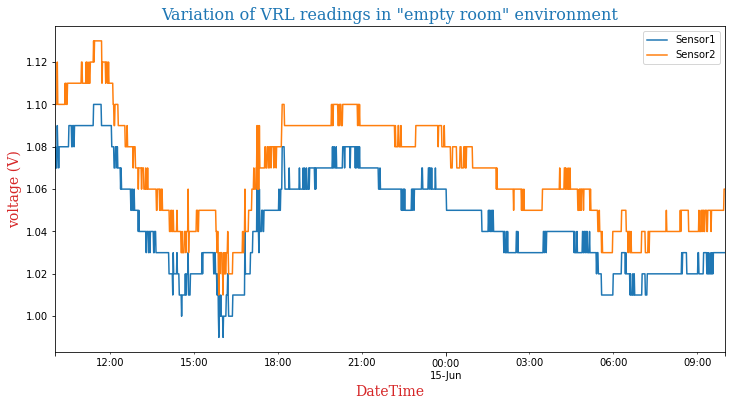

In [12]:
fdf = df[(df['date'] > '6/14/22 10:00 AM') & (df['date'] < '6/15/22 010:00 AM')]

ax = fdf.plot(x='date', y=["mq4_1","mq4_2"], 
              kind="line", figsize=(12, 6))

plt.title('Variation of VRL readings in "empty room" environment', fontdict=font_title)
plt.xlabel('DateTime',    fontdict=font)
plt.ylabel('voltage (V)', fontdict=font)
plt.legend(['Sensor1', 'Sensor2'], loc='best')


plt.show()

In [13]:
# MQ 4 Sensor1

sensor1['Rs'] = [Rs(sensor1['Vcc'] , v, sensor1['RL'] ) for v in mq4_1["mq4_1"]]
sensor1['Ratio'] = [Ratio(rs, sensor1['Ro']) for rs in sensor1['Rs']]

ppm1 = {}
for gas in GASES:
    ppm1[gas] = []

for r in sensor1['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm1[gas].append(PPM(r, m, b))

for gas in GASES:
    mq4_1[gas] = ppm1[gas]

In [14]:
# MQ 4 Sensor 2

sensor2['Rs'] = [Rs(sensor2['Vcc'] , v, sensor2['RL'] ) for v in mq4_2["mq4_2"]]
sensor2['Ratio'] = [Ratio(rs, sensor2['Ro']) for rs in sensor2['Rs']]
   
ppm2 = {}
for gas in GASES:
    ppm2[gas] = []
    
for r in sensor2['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm2[gas].append(PPM(r, m, b))
        
for gas in GASES:
    mq4_2[gas] = ppm2[gas]

In [15]:
mq4_1.describe()

,mq4_1,lpg,ch4,h2,co,alcohol,smoke
count,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000
mean,1.042839,36.903368,13.695280,75.894578,114.187856,46.087105,25.488930
std,0.021688,2.990414,1.046497,11.682926,43.869095,20.012971,11.837798
min,0.990000,30.189348,11.332298,51.882422,44.678740,16.003146,8.238407
25%,1.030000,35.101529,13.065407,68.755382,87.002863,33.707285,18.178834
50%,1.040000,36.424856,13.529898,73.675820,102.466533,40.470585,22.077069
75%,1.060000,39.192520,14.498341,84.475286,141.639219,58.116475,32.427700
max,1.100000,45.240185,16.601550,110.441073,267.107501,118.099239,68.880447


In [16]:
mq4_2.describe()

,mq4_2,lpg,ch4,h2,co,alcohol,smoke
count,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000
mean,1.066039,36.015632,13.383884,72.551196,102.928670,41.063098,22.555781
std,0.022955,3.033858,1.063276,11.586947,40.865484,18.422957,10.822835
min,1.010000,29.199636,10.981270,48.750829,38.557218,13.572929,6.915827
25%,1.050000,33.876736,12.634628,64.342439,74.361268,28.281786,15.086524
50%,1.060000,35.135702,13.077414,68.880457,87.377929,33.869750,18.271940
75%,1.090000,39.142202,14.480769,84.272832,140.837104,57.748720,32.209729
max,1.130000,45.055664,16.537623,109.601220,262.324867,115.738113,67.418255


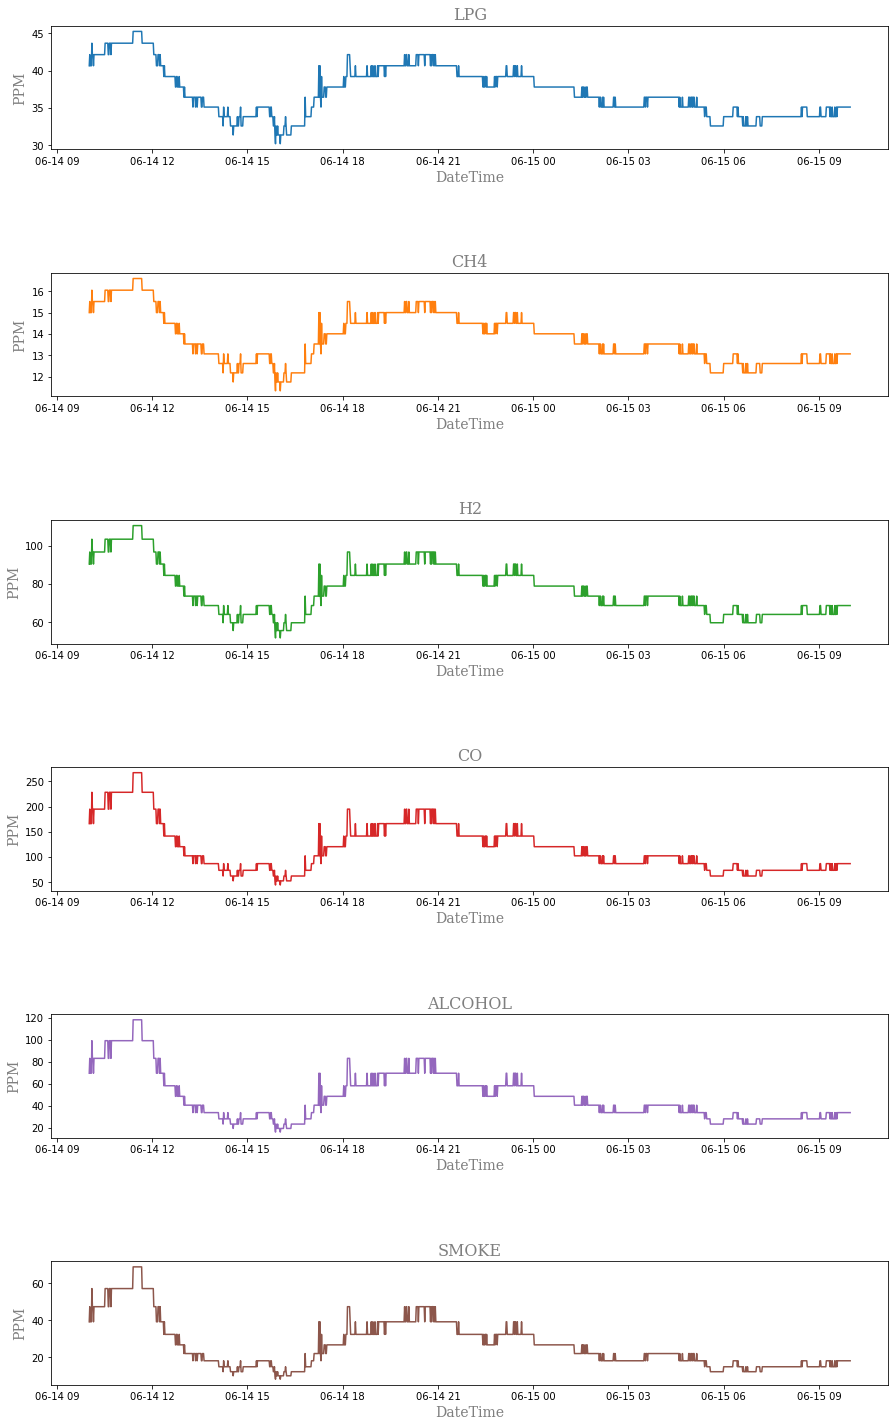

In [17]:
# Time Interval:
#           min: 2022-06-14 09:56:00
#           max: 2022-06-15 16:23:00 
  
fmq = mq4_1[(mq4_1['date'] > '6/14/22 10:00 AM') & (mq4_1['date'] < '6/15/22 010:00 AM')]

plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(len(GASES) * 100 + 11 + idx)
    plt.plot(fmq['date']         , fmq[GASES[idx]],        color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    


plt.show()


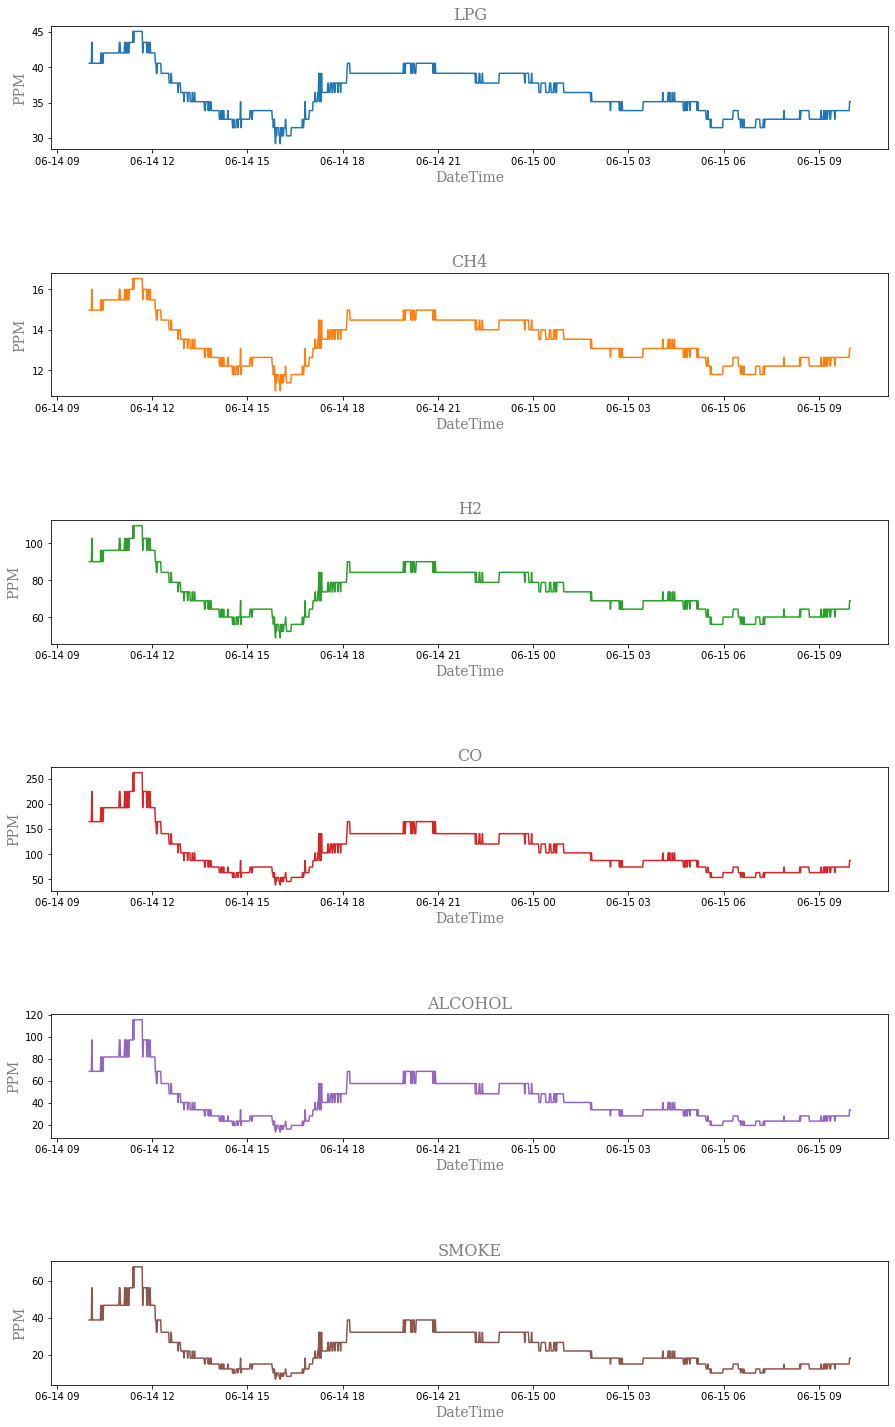

In [18]:
# Time Interval:
#           min: 2022-06-14 09:56:00
#           max: 2022-06-15 16:23:00 
  
fmq = mq4_2[(mq4_2['date'] > '6/14/22 10:00 AM') & (mq4_2['date'] < '6/15/22 010:00 AM')]

plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(len(GASES) * 100 + 11 + idx)
    plt.plot(fmq['date']         , fmq[GASES[idx]],        color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    


plt.show()


In [19]:
# Save in excel file
mq4_1.to_csv('mq4_1.csv')
mq4_2.to_csv('mq4_2.csv')